In [1]:
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt
import json

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

import cv2

%matplotlib inline

Using TensorFlow backend.


In [2]:
img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 1 # Number of positive classes
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size

In [3]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
model_path = 'ssd7_135.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

In [4]:
image_path = '../5.jpg'
img = cv2.imread(image_path)
import numpy as np
img = np.expand_dims(img, axis=0)
print(img.shape)
y_pred = model.predict(img)

# 4: Decode the raw prediction `y_pred`

y_pred_decoded = decode_detections(y_pred,
                                   confidence_thresh=0.5,
                                   iou_threshold=0.45,
                                   top_k=200,
                                   normalize_coords=normalize_coords,
                                   img_height=img_height,
                                   img_width=img_width)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_decoded)
#保存标注 到 json
fp = open('../5.json', 'w')
json_array = json.dumps(y_pred_decoded[0].tolist())
fp.write(json_array)
fp.close()

(1, 300, 480, 3)
Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[array([[  1.  ,   1.  , 150.2 ,  50.04, 311.21, 145.97],
       [  1.  ,   1.  ,   6.6 ,   5.39, 220.17,  97.58],
       [  1.  ,   0.97, 278.15,  10.53, 481.05,  92.17]])]


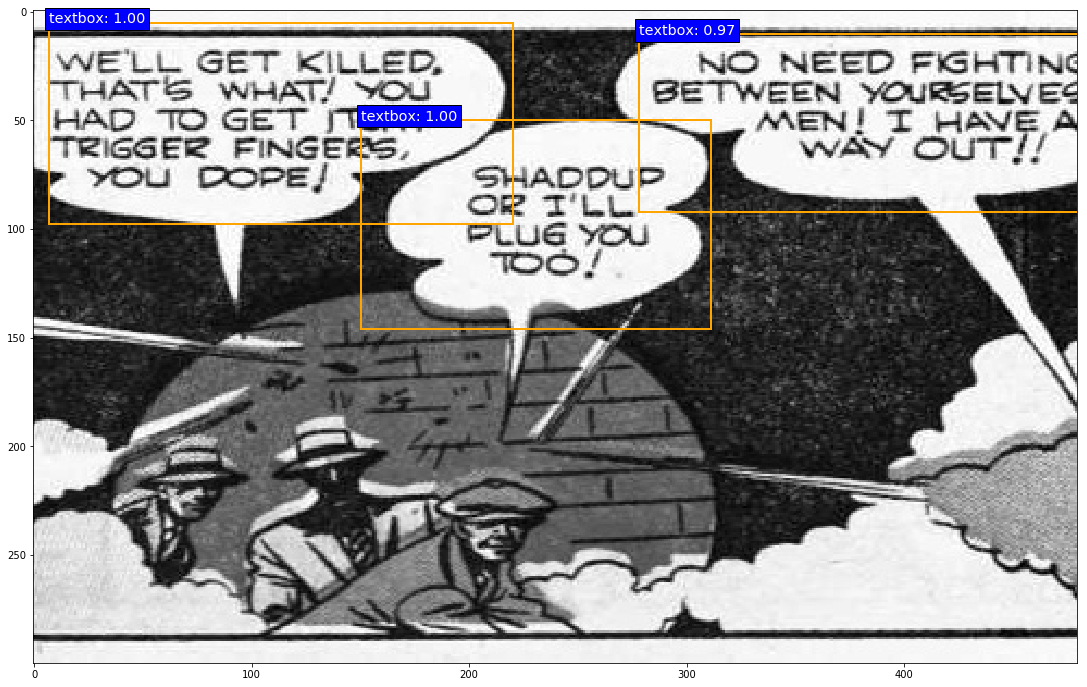

In [5]:
# 5: Draw the predicted boxes onto the image

plt.figure(figsize=(20,12))
plt.imshow(cv2.imread(image_path))

current_axis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, n_classes+1)).tolist() # Set the colors for the bounding boxes
classes = ['background', 'textbox'] # Just so we can print class names onto the image instead of IDs

# Draw the predicted boxes in blue
for box in y_pred_decoded[0]:
#     print(box)
#     print(box[-4])
    xmin = box[-4]
    ymin = box[-3]
    xmax = box[-2]
    ymax = box[-1]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='orange', fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})